In [1]:
#!mamba env create -f '../../environment.yml'
!mamba env update -f '../../environment.yml' --prune

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
pkgs/r/linux-64                                               No change
pkgs/r/noarch                                                 No change
pkgs/main/noarch                                              No change
pkgs/main/linux-64                                            No change


Looking for: ['python', 'numpy', 'pandas', 'xarray', 'matplotlib', 'wget', 'requests', 'urllib3', 'dask', 'gdal', 'rasterio', 'rioxarray', 'geopandas', 'shapely', 'contextily', 'earthaccess', 'ipykernel', 'pystac-client', 'planetary-computer', 'odc-stac', 'xee', 'pip']


Transaction

  Prefix: /home/eric/miniconda3/envs/easysnowdata

  Updating specs:

   - python
   - numpy
   - pandas
   - xarray
   - matplotlib
   - wget
   - requests
   - urllib3
   - dask
   - gdal
   - rasterio
   - rioxarray
   - geopandas
   - shapely
   - contextily
   - eart

# Testing examples from remote_sensing 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%aimport easysnowdata
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import shapely
import dask
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime

In [4]:
bbox_gdf = gpd.read_file('https://github.com/egagli/sar_snowmelt_timing/raw/main/input/shapefiles/mt_rainier.geojson')
#bbox_gdf = gpd.read_file('https://github.com/egagli/sar_snowmelt_timing/raw/main/input/shapefiles/olympic_peninsula.geojson')

## Forest cover fraction

In [5]:
%%time
forest_cover_fraction = easysnowdata.remote_sensing.get_forest_cover_fraction(bbox_gdf)
forest_cover_fraction

CPU times: user 23.4 ms, sys: 29 ms, total: 52.4 ms
Wall time: 4.91 s


<xarray.DataArray (y: 158, x: 232)> Size: 147kB
dask.array<getitem, shape=(158, 232), dtype=float32, chunksize=(158, 232), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -121.9 -121.9 -121.9 ... -121.6 -121.6 -121.6
  * y            (y) float64 1kB 46.95 46.95 46.95 46.95 ... 46.8 46.79 46.79
    spatial_ref  int64 8B 0
Attributes: (12/31)
    archive_facility:       VITO NV
    AREA_OR_POINT:          Area
    copyright:              Copernicus Service information 2020
    creator:                Dr. Marcel Buchhorn (VITO)
    delivered_product_crs:  WGS84 (EPSG:4326)
    doi:                    10.5281/zenodo.3939050
    ...                     ...
    time_reference_year:    2019
    title:                  Dynamic Land Cover Map 100m 2019-nrt
    band_crs:               WGS84 (EPSG:4326)
    short_name:             Tree-CoverFraction-layer
    unit:                   %
    valid_range:            0, 100

Text(0.5, 1.0, 'Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

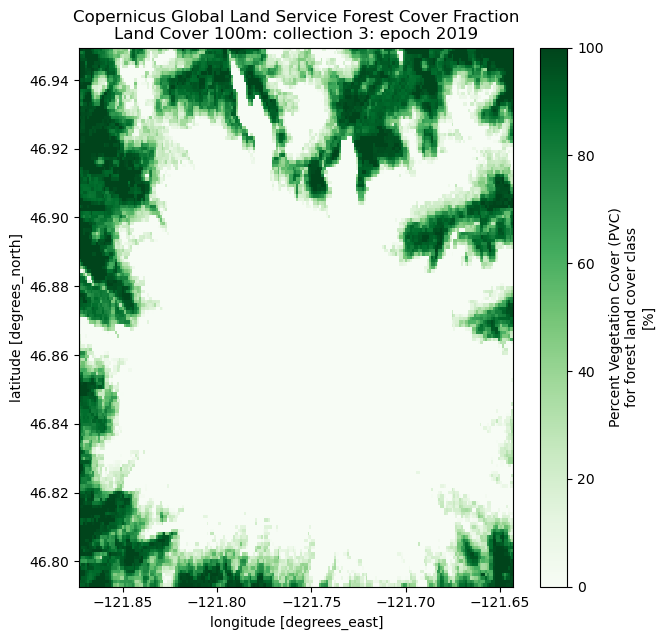

In [6]:
f,ax=plt.subplots(figsize=(7,7))

forest_cover_fraction.plot(ax=ax,cmap='Greens')

ax.set_title('Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

## Seasonal snow classification (Sturm & Liston 2021)

In [7]:
%%time
snow_classification = easysnowdata.remote_sensing.get_seasonal_snow_classification(bbox_gdf)
snow_classification

CPU times: user 19 ms, sys: 9.38 ms, total: 28.4 ms
Wall time: 2.48 s


<xarray.DataArray (y: 57, x: 84)> Size: 19kB
dask.array<getitem, shape=(57, 84), dtype=float32, chunksize=(30, 84), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 672B -121.9 -121.9 -121.9 ... -121.6 -121.6 -121.6
  * y            (y) float64 456B 46.95 46.95 46.94 46.94 ... 46.8 46.8 46.79
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         Band 1
    long_name:      Band 1
    class_info:     {1: {'name': 'Tundra', 'color': '#a100c8'}, 2: {'name': '...

Text(0.5, 1.0, 'Seasonal Snow Classification\nfrom Sturm & Liston 2021')

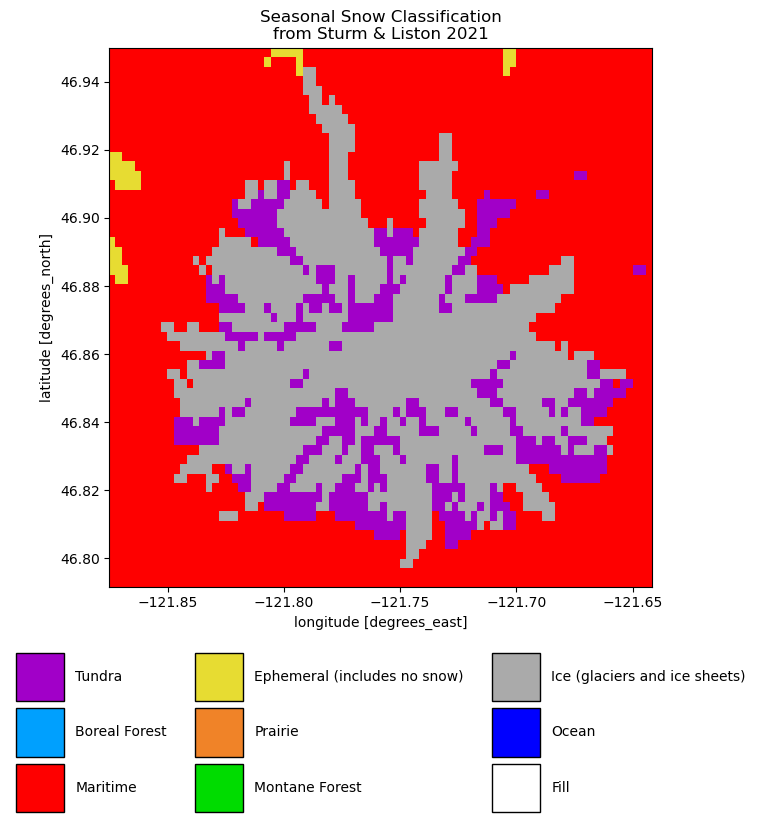

In [8]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in snow_classification.attrs['class_info'].values()]
class_colors = [class_info['color'] for class_info in snow_classification.attrs['class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(snow_classification.attrs['class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
snow_classification.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/3,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('Seasonal Snow Classification\nfrom Sturm & Liston 2021')

## ESA WorldCover

In [9]:
%%time
esa_worldcover = easysnowdata.remote_sensing.get_esa_worldcover(bbox_gdf)
esa_worldcover

CPU times: user 49.1 ms, sys: 0 ns, total: 49.1 ms
Wall time: 1.51 s


<xarray.DataArray 'map' (latitude: 1874, longitude: 2757)> Size: 5MB
dask.array<getitem, shape=(1874, 2757), dtype=uint8, chunksize=(1874, 2757), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 15kB 46.95 46.95 46.95 ... 46.79 46.79 46.79
  * longitude    (longitude) float64 22kB -121.9 -121.9 -121.9 ... -121.6 -121.6
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-01-01
Attributes:
    nodata:      0
    class_info:  {10: {'name': 'Tree cover', 'color': '#006400'}, 20: {'name'...

Text(0.5, 1.0, 'ESA WorldCover\n2021 v200')

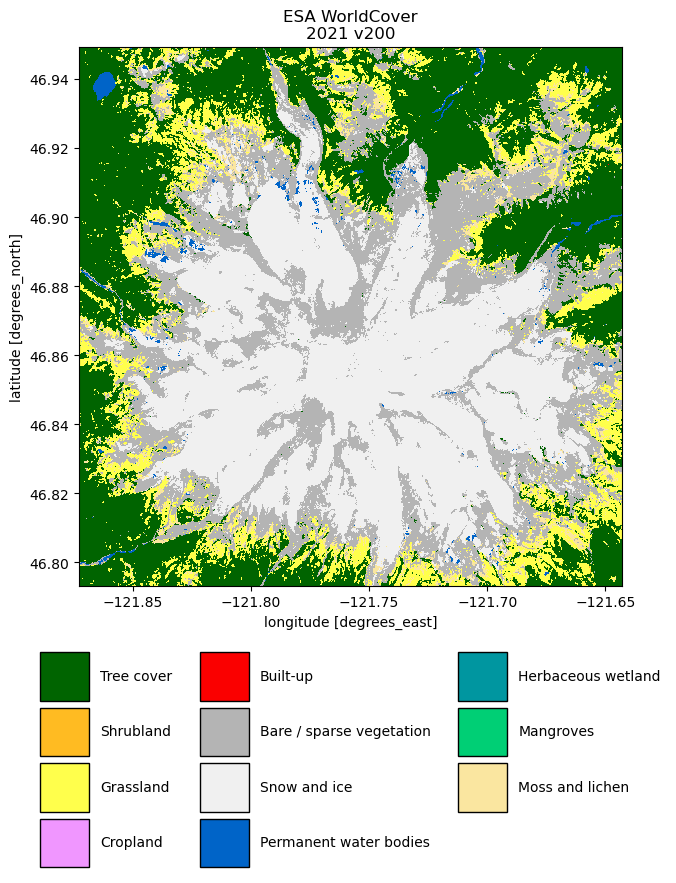

In [10]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in esa_worldcover.attrs['class_info'].values()]
class_colors = [class_info['color'] for class_info in esa_worldcover.attrs['class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(esa_worldcover.attrs['class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
esa_worldcover.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/3,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('ESA WorldCover\n2021 v200')

## Sentinel-2

In [11]:
s2 = easysnowdata.remote_sensing.Sentinel2(bbox_input=bbox_gdf, start_date='2022-01-01', end_date='2022-12-31', catalog_choice='planetarycomputer')

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.


In [12]:
s2.get_rgb()

RGB data retrieved. Access with the .rgb attribute.


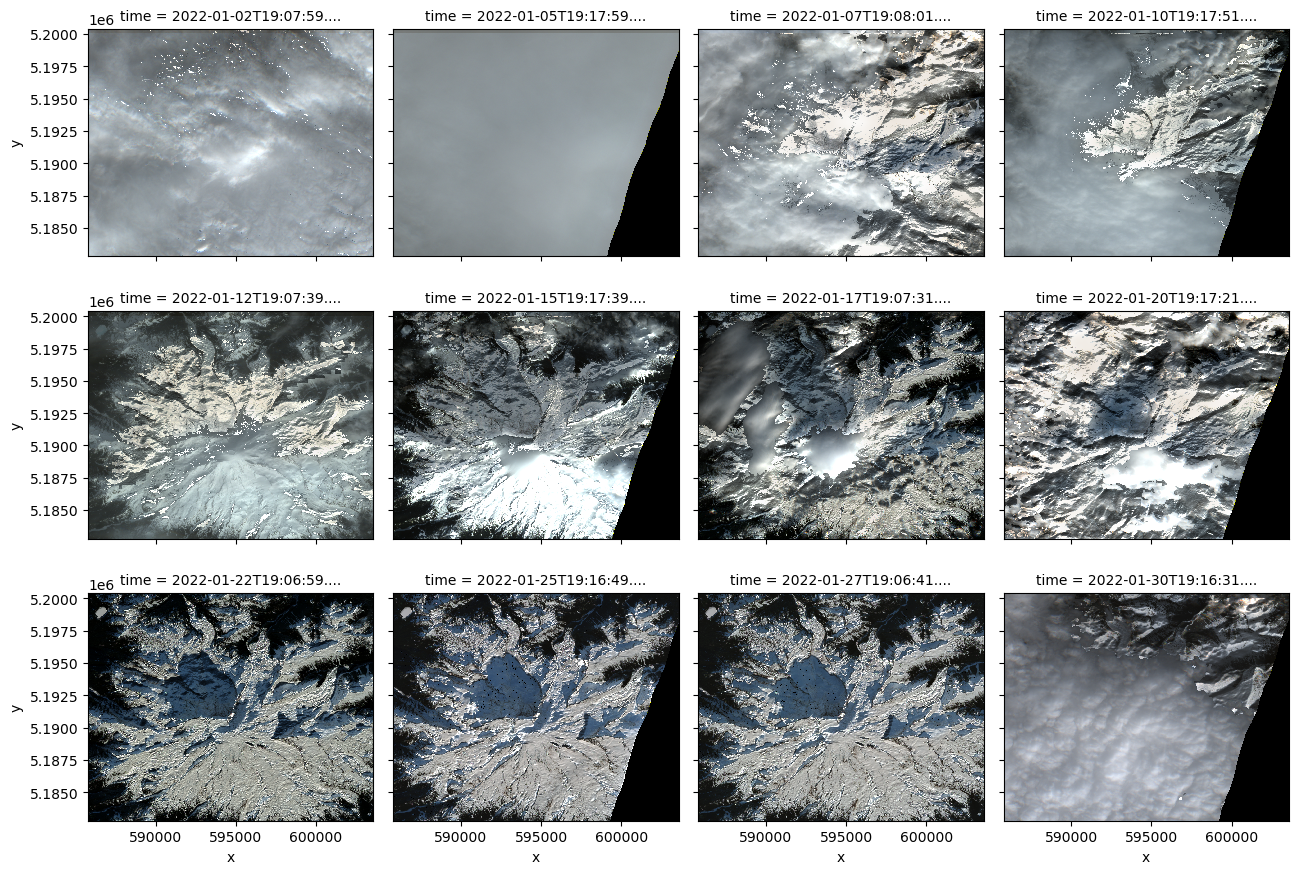

In [13]:
s2.rgb.isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4, robust=True)

In [14]:
scl_da = s2.data.scl.isel(time=10)

Text(0.5, 1.0, 'Sentinel-2 SCL')

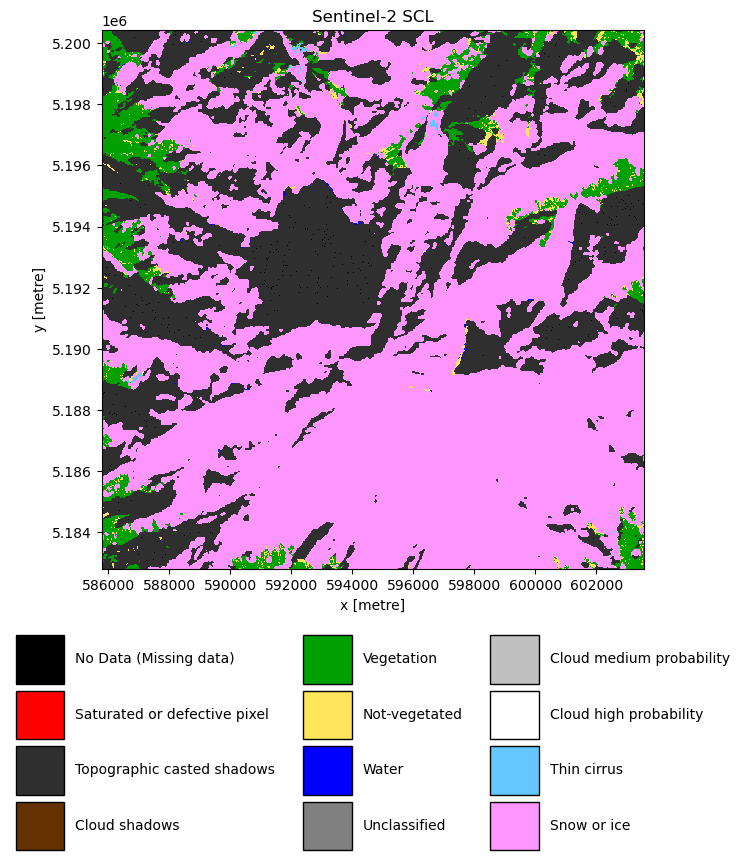

In [15]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in scl_da.attrs['scl_class_info'].values()]
class_colors = [class_info['color'] for class_info in scl_da.attrs['scl_class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(scl_da.attrs['scl_class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
scl_da.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/4,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('Sentinel-2 SCL')

In [16]:
s2.mask_data()

Removed pixels with the following scene classification values:
No Data (Missing data)
Saturated or defective pixel
Topographic casted shadows
Cloud shadows
Cloud medium probability
Cloud high probability
Thin cirrus


In [17]:
s2.get_ndsi()

NDSI data calculated. Access with the .ndsi attribute.


/home/eric/miniconda3/envs/easysnowdata/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
Aborting load due to failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TFT.2020001T191811.v2.0/HLS.S30.T10TFT.2020001T191811.v2.0.B04.tif:1
Aborting load due to failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TFT.2020001T191811.v2.0/HLS.S30.T10TFT.2020001T191811.v2.0.B04.tif:1
Aborting load due to failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TFT.2020001T191811.v2.0/HLS.S30.T10TFT.2020001T191811.v2.0.B04.tif:1
Aborting load due to failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TFT.2020001T191811.v2.0/HLS.S30.T10TFT.2020001T191811.v2.0.B04.tif:1


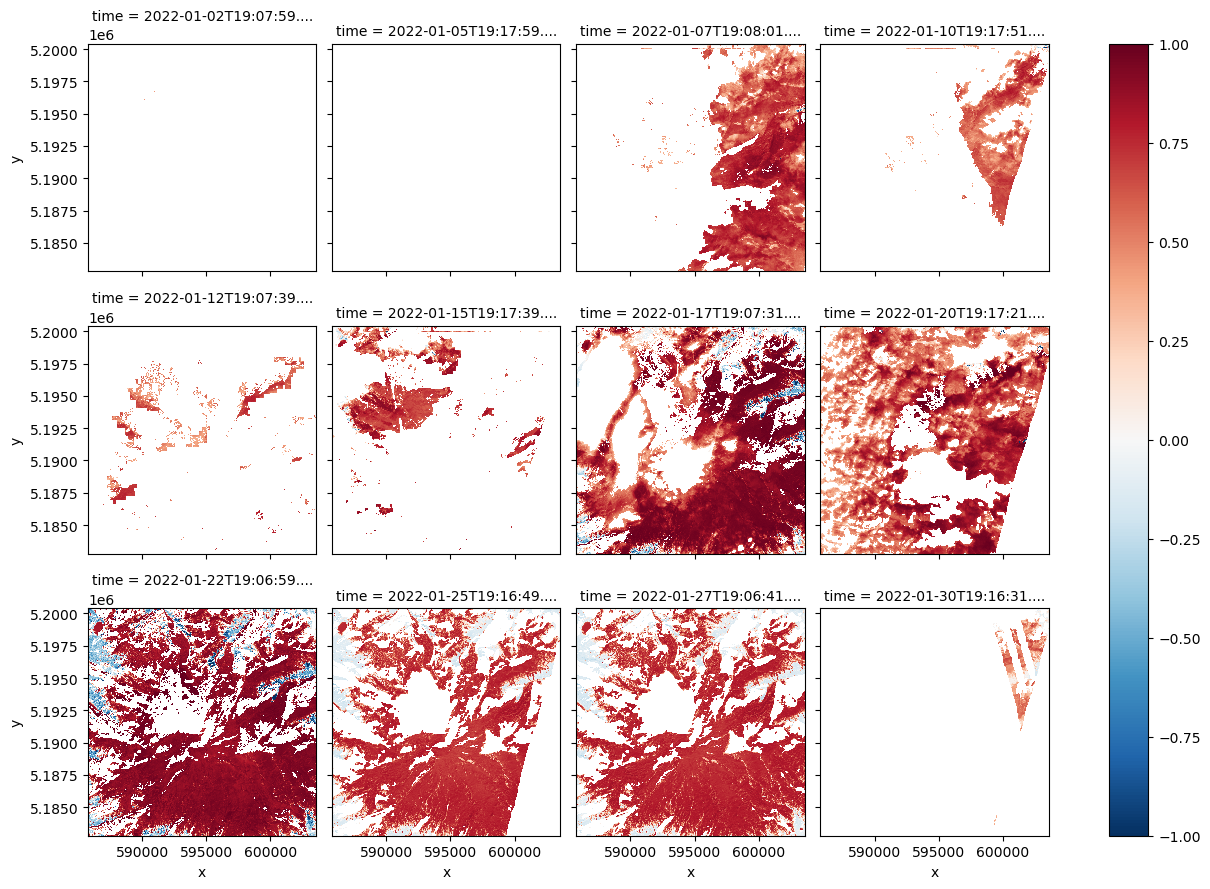

In [ ]:
s2.ndsi.isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4)

In [ ]:
s2.get_ndvi()

NDVI data calculated. Access with the .ndvi attribute.


KeyboardInterrupt: 

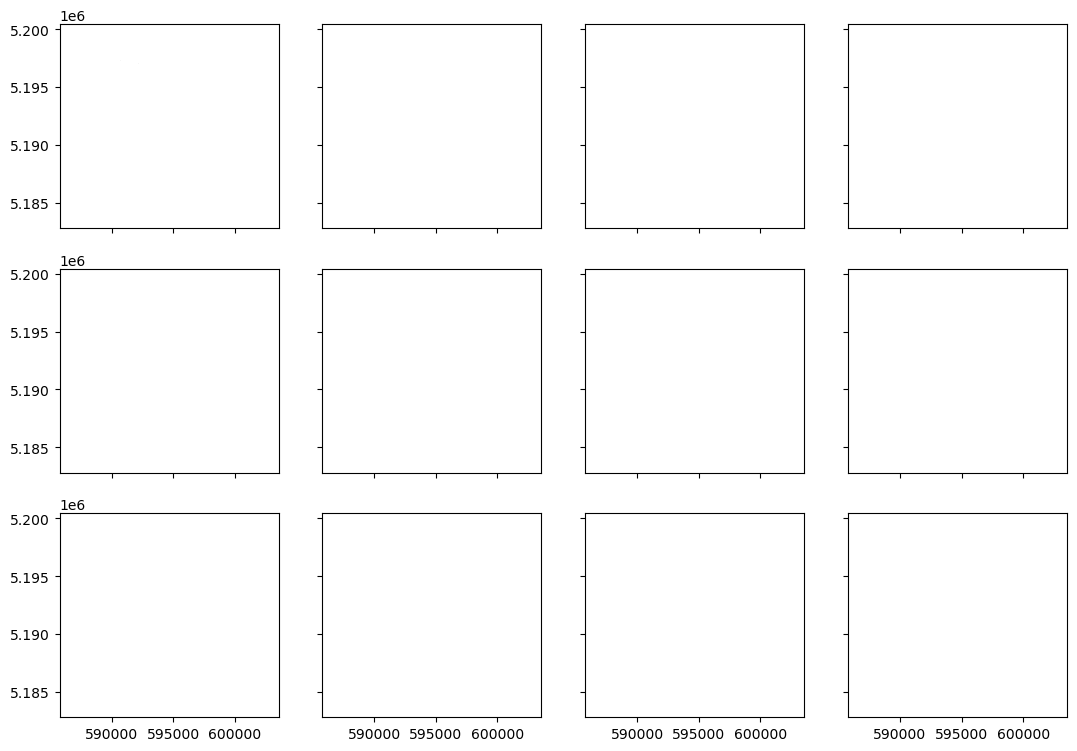

In [ ]:
s2.ndvi.isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4)

## Sentinel-1

In [ ]:
#!gdalinfo "https://zenodo.org/record/3939050/files/PROBAV_LC100_global_v3.0.1_2019-nrt_Tree-CoverFraction-layer_EPSG-4326.tif"
#!gdalinfo 'https://snowmelt.blob.core.windows.net/snowmelt/eric/snow_classification/SnowClass_GL_300m_10.0arcsec_2021_v01.0.tif'

In [18]:
s1 = easysnowdata.remote_sensing.Sentinel1(bbox_input=bbox_gdf, start_date='2022-01-01', end_date='2022-12-31')

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.
Border noise removed from the data.
Added relative orbit number and orbit state as coordinates to the data.
Linear power units converted to dB. Convert back to linear power units using the .db_to_linear() method.


In [19]:
s1.data

<xarray.Dataset> Size: 2GB
Dimensions:             (y: 1763, x: 1779, time: 95)
Coordinates:
  * y                   (y) float64 14kB 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
  * x                   (x) float64 14kB 5.858e+05 5.858e+05 ... 6.036e+05
    spatial_ref         int32 4B 32610
  * time                (time) datetime64[ns] 760B 2022-03-14T01:54:07.509244...
    sat:orbit_state     (time) object 760B 'ascending' ... 'descending'
    sat:relative_orbit  (time) int16 190B 64 115 137 64 115 ... 137 13 64 115
Data variables:
    vh                  (time, y, x) float32 1GB dask.array<chunksize=(95, 512, 512), meta=np.ndarray>
    vv                  (time, y, x) float32 1GB dask.array<chunksize=(95, 512, 512), meta=np.ndarray>
Attributes:
    units:    dB

<Axes: >

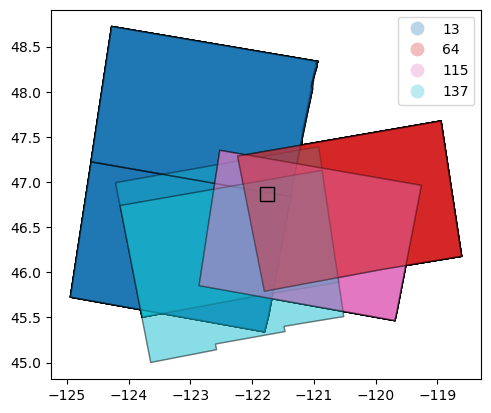

In [20]:
f,ax=plt.subplots()

s1.metadata.plot('sat:relative_orbit', ax=ax,edgecolor='black', categorical=True, legend=True, alpha=0.3)
bbox_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

In [ ]:
import earthaccess

In [ ]:
results = earthaccess.search_data(
    short_name='MOD10A1F',
    cloud_hosted=True,
    bounding_box=tuple(bbox_gdf.total_bounds),
    temporal=('2022-01-01', '2022-01-05'),
)

#    temporal=(f"{time}",f"{time}")

In [ ]:
earthaccess.login()

In [ ]:
files=earthaccess.open(results)

In [ ]:
files

In [ ]:
import h5netcdf

In [ ]:
ds = xr.open_mfdataset(files,chunks={})

In [ ]:


        temp_download_fp = '/tmp/local_folder'

        files = earthaccess.download(results, temp_download_fp)

        modis = rxr.open_rasterio(*files,mask_and_scale=True).squeeze()


        modis_ndsi = modis['CGF_NDSI_Snow_Cover'].where(modis['CGF_NDSI_Snow_Cover']<=100,np.nan)
        
        modis_ndsi_dict[rel_orbit] = modis_ndsi.rio.reproject_match(dataset)

        shutil.rmtree(temp_download_fp)
    

In [ ]:
!pip install --upgrade xee

In [ ]:
import ee

In [ ]:
import xarray as xr

In [ ]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')


In [ ]:
ds = xr.open_dataset('ee://NASA/HLS/HLSL30/v002', engine='ee')


In [ ]:
!CPL_VSIL_CURL_USE_HEAD=FALSE
!GDAL_DISABLE_READDIR_ON_OPEN=YES
!GDAL_HTTP_COOKIEJAR=/tmp/cookies.txt
!GDAL_HTTP_COOKIEFILE=/tmp/cookies.txt

In [ ]:
import rasterio as rio
import os
rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
                  CPL_VSIL_CURL_USE_HEAD='FALSE',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

In [21]:
#!pip install GDAL

In [22]:
from osgeo import gdal

In [23]:
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')

In [24]:
BAND_CROSSWALK = {
    "HLSL30.v2.0": {
        "B01": "coastal aerosol",
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "nir narrow",
        "B06": "swir 1",
        "B07": "swir 2",
        "B09": "cirrus",
        "B10": "thermal infrared 1",
        "B11": "thermal",
    },
    "HLSS30.v2.0": {
        "B01": "coastal aerosol",
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "red-edge 1",
        "B06": "red-edge 2",
        "B07": "red-edge 3",
        "B08": "nir broad",
        "B8A": "nir narrow",
        "B09": "water vapor",
        "B10": "cirrus",
        "B11": "swir 1",
        "B12": "swir 2",
    },
}


In [91]:
catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")


In [92]:
catalog

<Client id=LPCLOUD>

In [93]:
L_stac_items = catalog.search(collections=["HLSL30.v2.0"],bbox=bbox_gdf.total_bounds, datetime=('2022-01-01','2022-02-01')).item_collection()
S_stac_items = catalog.search(collections=["HLSS30.v2.0"],bbox=bbox_gdf.total_bounds, datetime=('2022-01-01','2022-02-01')).item_collection()

In [94]:
for item in L_stac_items:
    for original_band, new_band in BAND_CROSSWALK.get(item.collection_id).items():
        item.assets[new_band] = item.assets.pop(original_band)
        
for item in S_stac_items:
    for original_band, new_band in BAND_CROSSWALK.get(item.collection_id).items():
        item.assets[new_band] = item.assets.pop(original_band)

In [95]:
L30_ds = odc.stac.load(L_stac_items,crs='utm',resolution=30,groupby='solar_day',chunks={},bbox=bbox_gdf.total_bounds,dtype='int16',nodata=-9999,scale=0.0001) #,chunks={'time':1,'x':512,'y':512},fail_on_error=False

In [96]:
S30_ds = odc.stac.load(S_stac_items,crs='utm',resolution=30,groupby='solar_day',chunks={},bbox=bbox_gdf.total_bounds,dtype='int16',nodata=-9999,scale=0.0001)

In [97]:
testing = xr.concat((L30_ds, S30_ds), dim='time').sortby("time")

In [98]:
testing

<xarray.Dataset> Size: 391MB
Dimensions:             (y: 588, x: 593, time: 20)
Coordinates:
  * y                   (y) float64 5kB 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
  * x                   (x) float64 5kB 5.858e+05 5.858e+05 ... 6.036e+05
    spatial_ref         int32 4B 32610
  * time                (time) datetime64[ns] 160B 2022-01-01T18:55:53.980000...
Data variables: (12/21)
    Fmask               (time, y, x) int16 14MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    SAA                 (time, y, x) int16 14MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    VZA                 (time, y, x) int16 14MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    VAA                 (time, y, x) int16 14MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    SZA                 (time, y, x) int16 14MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    browse              (time, y, x) int16 14MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    ...                  ...
    thermal             (time, y, x) float32 28MB dask.array<chunksize=(1, 588, 593), meta=np.ndarray>
    red-edge 1          (time, y, x) float32 28MB dask.array<chunksize=(3, 588, 593), meta=np.ndarray>
    red-edge 2          (time, y, x) float32 28MB dask.array<chunksize=(3, 588, 593), meta=np.ndarray>
    red-edge 3          (time, y, x) float32 28MB dask.array<chunksize=(3, 588, 593), meta=np.ndarray>
    nir broad           (time, y, x) float32 28MB dask.array<chunksize=(3, 588, 593), meta=np.ndarray>
    water vapor         (time, y, x) float32 28MB dask.array<chunksize=(3, 588, 593), meta=np.ndarray>

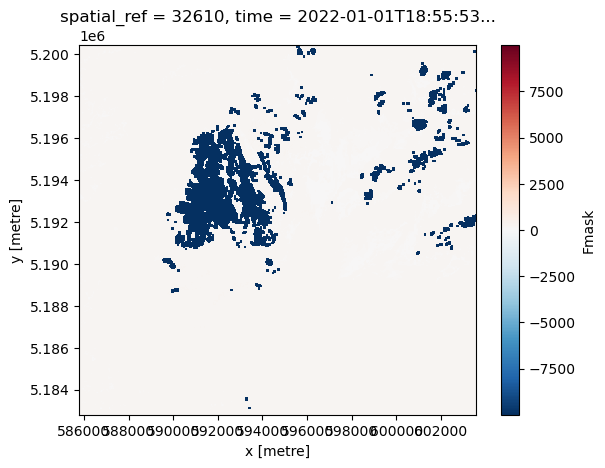

In [99]:
testing['Fmask'].isel(time=0).plot.imshow()

In [100]:
testing['red'].rio.nodata

-9999

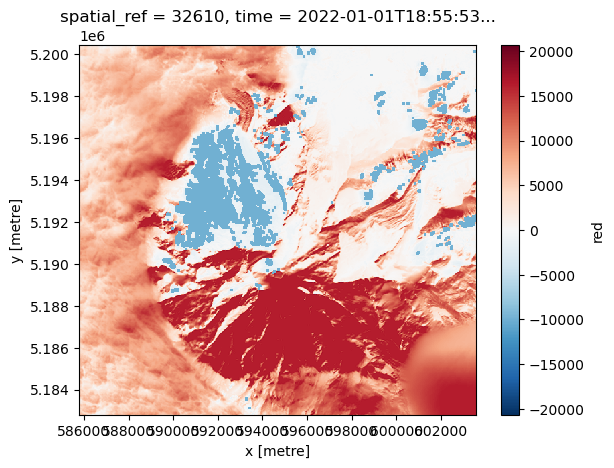

In [101]:
testing['red'].isel(time=0).plot.imshow()

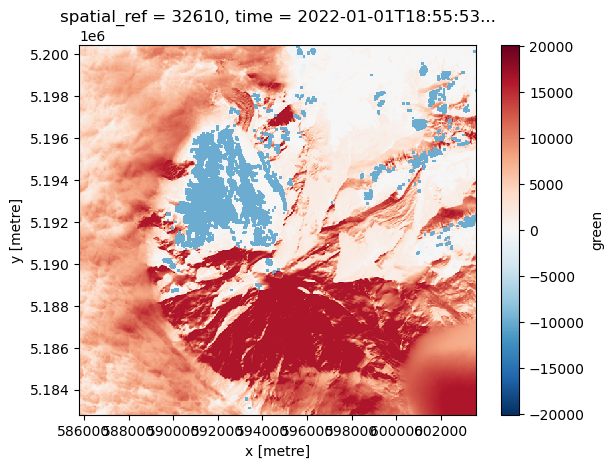

In [102]:
testing['green'].isel(time=0).plot.imshow()

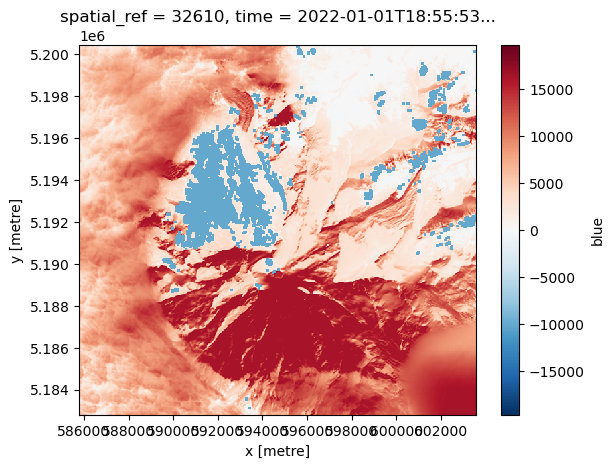

In [103]:
testing['blue'].isel(time=0).plot.imshow()

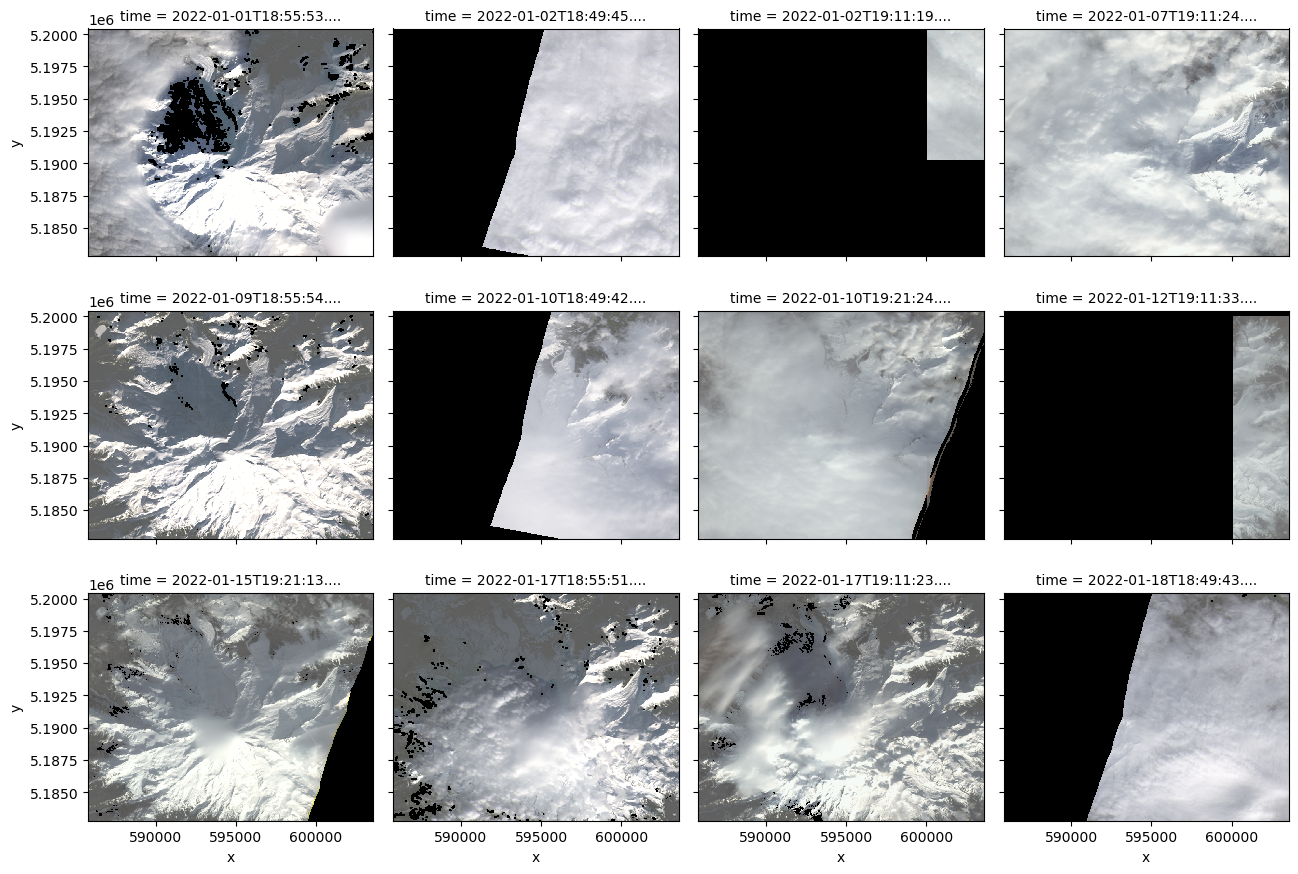

In [104]:
testing[['red','green','blue']].to_dataarray(dim='band').isel(time=slice(0,12)).plot.imshow(col='time',col_wrap=4,robust=True)#.plot.imshow(col='time',col_wrap=4,robust=True)#(band='rgb')

In [ ]:
S30_ds['red'].isel(time=0).plot()

RasterioIOError: '/vsicurl/https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TFT.2020001T191811.v2.0/HLS.S30.T10TFT.2020001T191811.v2.0.B04.tif' not recognized as a supported file format.

In [ ]:
L30_ds['red'].isel(time=0).plot()

RasterioIOError: '/vsicurl/https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2020005T184940.v2.0/HLS.L30.T10TES.2020005T184940.v2.0.B04.tif' not recognized as a supported file format.

In [ ]:
!pip install -q stackstac
import stackstac

In [ ]:
#https://hrodmn.dev/posts/hls/
#https://github.com/hrodmn/hls-tools/blob/main/hls_tools/__init__.py
#https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html
stackstac.stack(stac_items,bounds=bbox_gdf.total_bounds, assets=['red','green','blue'], epsg=32610,resolution=30)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
odc.stac.extract_collection_metadata(item)

In [ ]:
odc.stac.load(stac_items,bbox=bbox_gdf.total_bounds,chunks={},crs='utm',resolution=30, fail_on_error=False)

In [ ]:
#HLS https://lpdaac.usgs.gov/documents/842/HLS_Tutorial.html


#import folium
# try reduced res
# rgba_test = s2.data[['red','green','blue']].odc.to_rgba(vmin=0,vmax=15000)
# _map = folium.Map()
# rgba_test.isel(time=10).odc.add_to(_map,fmt='png')
# _map.fit_bounds(rgba_test.odc.map_bounds())
# s2.metadata.explore('s2:mgrs_tile',m=_map,style_kwds=dict(fillOpacity=0, width=0.3, opacity=0.3),popup=True)


#import hvplot.xarray
#!pip install hvplot
#!pip install jupyter_bokeh
#s2.rgb.hvplot.rgb('x', 'y', bands='band',  groupby='time', frame_width=600,robust=True)
